In [1]:
import pyspark as ps
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("yelp_academic") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [2]:
from train_model import str_to_l, if_rest_udf, str_to_list_udf, construct_set_for_ALS

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

In [38]:
from train_model import hash_udf, norm_pred_udf

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [5]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
from pyspark.sql.functions import udf

In [22]:
from pymongo import MongoClient

mc = MongoClient()
db  = mc['raw_restaurants']
bisn = db['restaurants']
users = db['users']
rv = db['reviews']
rv_s = db['reviews_scrap']

In [6]:
biz = spark.read.json('yelp_dataset/yelp_academic_dataset_business.json')

rev = spark.read.json('yelp_dataset/yelp_academic_dataset_review.json')

user = spark.read.json('yelp_dataset/yelp_academic_dataset_user.json')

<i> Next cell is not need for now </i>

In [24]:
biz.createOrReplaceTempView('business')
rev.createOrReplaceTempView('reviews')

In [27]:
biz.count(), rev.count()

(188593, 5996996)

In [7]:
rests = biz.filter(if_rest_udf(biz.categories))

In [7]:
rests.cache()

DataFrame[address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string

In [79]:
#rests = rests.withColumn('categories', str_to_list_udf(rests.categories))

In [93]:
##Wanna try two ways
rests.createOrReplaceTempView('rests')
rev.createOrReplaceTempView('reviews')

In [8]:
rest_id = rests.select('business_id')

In [9]:
rest_id.createOrReplaceTempView('rests_id')

In [98]:
%%time
select = '''
SELECT  reviews.* 
FROM rests_id 
LEFT JOIN reviews ON rests_id.business_id == reviews.business_id


'''
rest_rev = spark.sql(select)
rest_rev.show(5)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|--9e1ONYQuAa-CB_R...|   0|2014-02-25|    0|8eEp26oqTXmuIjVUJ...|    3|It was a real up ...|     0|AdxhlxXSGjRsCQxG6...|
|--9e1ONYQuAa-CB_R...|   0|2017-02-14|    0|VETXTwMw6qxzOVDlX...|    5|went for dinner t...|     0|ymlnR8UeFvB4FZL56...|
|--9e1ONYQuAa-CB_R...|   0|2013-12-19|    0|NQt645IJwa5ADM26U...|    5|we are a repeat c...|     0|TMqFvYbWqs8BnjLsE...|
|--9e1ONYQuAa-CB_R...|   0|2013-12-02|    2|G9TSEZ8BfuSmcf5xy...|    3|Thanksgiving dinn...|     5|KmubWHd-t2d3dxLZ1...|
|--9e1ONYQuAa-CB_R...|   0|2015-01-01|    0|6prMgAjp2LZjuxRvm...|    4|We were seated pr...|     0|bMFqD4beGrt_LjNGG...|
+--------------------+----+-----

In [9]:
%%time
rest_rev2 = rev.join(rest_id, "business_id")
rest_rev2.show(5)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|iCQpiavjjPzJ5_3gP...|   0|2011-02-25|    0|x7mDIiDB3jEiPGPHO...|    2|The pizza was oka...|     0|msQe1u7Z_XuqjGoqh...|
|pomGBqfbxcqPv14c3...|   0|2012-11-13|    0|dDl8zu1vWPdKGihJr...|    5|I love this place...|     0|msQe1u7Z_XuqjGoqh...|
|jtQARsP6P-LbkyjbO...|   1|2014-10-23|    1|LZp4UX5zK3e-c5ZGS...|    1|Terrible. Dry cor...|     3|msQe1u7Z_XuqjGoqh...|
|elqbBhBfElMNSrjFq...|   0|2011-02-25|    0|Er4NBWCmCD4nM8_p1...|    2|Back in 2005-2007...|     2|msQe1u7Z_XuqjGoqh...|
|Ums3gaP2qM3W1XcA5...|   0|2014-09-05|    0|jsDu6QEJHbwP2Blom...|    5|Delicious healthy...|     0|msQe1u7Z_XuqjGoqh...|
+--------------------+----+-----

### Join faster??? after lunch try in diff order

In [10]:
rest_rev2.count()

3654797

In [11]:
rev.join?

In [11]:
rest_rev2.cache()

DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: bigint, text: string, useful: bigint, user_id: string]

Baseline --- predict just mean rest rating

In [12]:
base_pred = rests.select('business_id', 'stars').withColumnRenamed('stars',
'mean_rating').join(rev.select('business_id', 'stars'), 'business_id')

In [14]:
base_pred.count()

3654797

In [13]:
baseline_rdd =base_pred.rdd


In [18]:
ev_b = RegressionEvaluator(labelCol="stars",predictionCol="mean_rating")
ev_b.evaluate(base_pred)

1.240991079593336

In [165]:
def look_how_dence_rating_matrix(rev, m):
    rating = rev.select('user_id', 'business_id', 'stars')
    user_id = rating.select('user_id').groupBy('user_id').count().selectExpr('user_id', 'count AS user_count')
    
    filt_rat = user_id.filter(user_id.user_count>m).join(rating, 'user_id')
    u  = user_id.filter(user_id.user_count>m).count()
    v = filt_rat.select('business_id').groupBy('business_id').count().count()
    r = filt_rat.count()
    k = r/(u+v)
    return u, v, r, k

In [166]:
look_how_dence_rating_matrix(rest_rev2,10)

(56425, 55341, 1611480, 14.418338313977417)

In [167]:
%%time
m_k = {}
for m in range(20):
    m_k[m] = look_how_dence_rating_matrix(rest_rev2,m)

CPU times: user 496 ms, sys: 184 ms, total: 680 ms
Wall time: 16min 26s


In [168]:
m_k

{0: (1031840, 57173, 3654797, 3.356063701718896),
 1: (464515, 57049, 3087472, 5.919641693061638),
 2: (292072, 56861, 2742586, 7.859921532213921),
 3: (207596, 56683, 2489158, 9.41867496093144),
 4: (157816, 56483, 2290038, 10.686181456749681),
 5: (125431, 56287, 2128113, 11.71107430194037),
 6: (103142, 56090, 1994379, 12.52498869573955),
 7: (86606, 55915, 1878627, 13.181404845601701),
 8: (74139, 55737, 1778891, 13.696841602759555),
 9: (64410, 55537, 1691330, 14.100644451299324),
 10: (56425, 55341, 1611480, 14.418338313977417),
 11: (50120, 55161, 1542125, 14.647704714050969),
 12: (44882, 55003, 1479269, 14.80972117935626),
 13: (40438, 54841, 1421497, 14.919310656073216),
 14: (36842, 54667, 1371153, 14.98380487165197),
 15: (33691, 54504, 1323888, 15.010918986337094),
 16: (30959, 54338, 1280176, 15.008452817801329),
 17: (28556, 54197, 1239325, 14.976194216523872),
 18: (26490, 54054, 1202137, 14.925220997218911),
 19: (24724, 53929, 1168583, 14.857449811196012)}

In [19]:
rest_rev2.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [20]:
rating = rest_rev2.select('business_id','stars','user_id')
train_set = construct_set_for_ALS(rating, 12)

In [22]:
%%time
train_set.first()

CPU times: user 10.4 ms, sys: 8.95 ms, total: 19.4 ms
Wall time: 40.4 s


Row(user_id='-55DgUo52I3zW9RxkZ-EAQ', business_id='wHq1efQVz17338k_aUOX3w', stars=5, user_count=16)

In [16]:
train_set.cache()

DataFrame[user_id: string, business_id: string, stars: bigint, user_count: bigint]

In [23]:
%%time
train_set = train_set.withColumn('user_num', hash_udf(train_set.user_id) )
train_set = train_set.withColumn('biz_num', hash_udf(train_set.business_id) )
print(train_set.columns)

['user_id', 'business_id', 'stars', 'user_count', 'user_num', 'biz_num']
CPU times: user 15.2 ms, sys: 5.97 ms, total: 21.1 ms
Wall time: 55.9 ms


In [25]:
train_set.randomSplit?

In [24]:
splits = train_set.randomSplit([0.8, 0.2], seed = 91)

In [25]:
train = splits[0]
test = splits[1]

In [26]:
%%time
als = ALS(rank=10, maxIter=5, seed=0, userCol='user_num', itemCol='biz_num', ratingCol='stars')
model = als.fit(train)

CPU times: user 87.6 ms, sys: 36.1 ms, total: 124 ms
Wall time: 1min 13s


In [30]:
%%time
model.coldStartStrategy
#### add with value drop

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


Param(parent='ALS_4afcb9dcb1d85fe191f4', name='coldStartStrategy', doc='strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: nan,drop.')

In [27]:
%%time
model.save('model2')

CPU times: user 4.22 ms, sys: 2.5 ms, total: 6.72 ms
Wall time: 2.06 s


In [28]:
biz_f = model.itemFactors
user_f = model.userFactors

biz_factors_df =biz_f.toPandas()
user_factors_df = user_f.toPandas()

In [36]:
biz_f.first()

Row(id=-2147478070, features=[0.4443496763706207, 0.7729302644729614, -0.49823057651519775, 1.9858793020248413, -0.03527529537677765, 0.405096173286438, -0.48111492395401, 0.09006907045841217, 1.0604867935180664, 0.14194419980049133])

In [30]:
evaluator = RegressionEvaluator(labelCol="stars",predictionCol="prediction")

In [31]:
train_res = model.transform(train)
test_res = model.transform(test)

In [39]:
#norm_pred_udf
train_res.withColumn('prediction', norm_pred_udf(train_res.prediction))
test_res.withColumn('prediction', norm_pred_udf(test_res.prediction))


DataFrame[user_id: string, business_id: string, stars: bigint, user_count: bigint, user_num: int, biz_num: int, prediction: double]

In [40]:
test_res1 = test_res.na.drop()
test_res2 = test_res.fillna(3.6)

In [41]:
%%time
evaluator.evaluate(train_res), evaluator.evaluate(test_res1), evaluator.evaluate(test_res2)

CPU times: user 195 ms, sys: 83.2 ms, total: 278 ms
Wall time: 3min 27s


(0.6898926060938879, 1.2616082401034254, 1.262127892103838)

In [42]:
test_res2.count(), test_res1.count()

(295042, 293669)

In [44]:
test_res1_base = test_res1.join(rests.select('business_id', 'stars').withColumnRenamed('stars',
'mean_rating'), 'business_id')
test_res1_base.columns

['business_id',
 'user_id',
 'stars',
 'user_count',
 'user_num',
 'biz_num',
 'prediction',
 'mean_rating']

In [46]:
test_res1_base.count()

293669

In [45]:
ev_b.evaluate(test_res1_base)

1.0991003667424148

In [47]:
train_base = train_res.join(rests.select('business_id', 'stars').withColumnRenamed('stars',
'mean_rating'), 'business_id')
ev_b.evaluate(train_base)

1.103362546461427

In [96]:
%%time
als2 = ALS(rank=6, maxIter=7, seed=0, userCol='user_num', itemCol='biz_num', ratingCol='stars')
model2 = als2.fit(train)

train2_res = model2.transform(train)
test2_res = model2.transform(test)
train2_res.withColumn('prediction', norm_pred_udf(train2_res.prediction))
test2_res.withColumn('prediction', norm_pred_udf(test2_res.prediction))
test2_res1 = test2_res.na.drop()

CPU times: user 99 ms, sys: 50.9 ms, total: 150 ms
Wall time: 1min 17s


In [97]:
evaluator.evaluate(train2_res), evaluator.evaluate(test2_res1)

(0.759613772807675, 1.222747798175471)

In [98]:
biz_f = model2.itemFactors
user_f = model2.userFactors

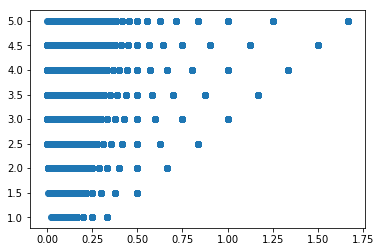

In [58]:
fig, ax = plt.subplots()
ax.scatter(rs.stars/rs.review_count, rs.stars)

In [65]:
rs['biz_num'] = rs['business_id'].map(hash)

In [91]:
rests.select('attributes.RestaurantsPriceRange2').take(2)


[Row(RestaurantsPriceRange2='2'), Row(RestaurantsPriceRange2='2')]

In [89]:
rests.columns


['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [ ]:
to_save = rests.select('attributes.RestaurantsPriceRange2', 'business_id', 'stars', 'review_count', 'categories')
to_save = to_save.withColumn('biz_num', hash_udf(to_save.business_id))

In [103]:
to_save = to_save.join(biz_f, to_save.biz_num == biz_f.id, how = 'left')
to_save.columns

['RestaurantsPriceRange2',
 'business_id',
 'stars',
 'review_count',
 'categories',
 'biz_num',
 'id',
 'features']

In [104]:
to_save.count(), biz_f.count()


(57173, 53931)

In [ ]:
to_save.toPandas.to_csv()